In [ ]:
# Imports
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import pickle
from time import time
from tensorflow.keras.preprocessing import image as kimage

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import

In [ ]:
def imreads(path):
    """
    This reads all the images in a given folder and returns the results
    """
    images_path = [os.path.join(path, f) for f in os.listdir(path)]
    images = []
    for image_path in images_path:
        # print(image_path)
        img = cv2.imread(image_path, flags=cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return images

dictionary_size = 1024

# Loading images
imgs_data = []

# imreads returns a list of all images in that directory
t0 = time()
imgs = imreads('Data/Train/')
print("Time required: %0.3f seconds." % (time() - t0))

## AKAZE Descriptors

In [ ]:
for i in range(len(imgs)):
    # create a numpy to hold the histogram for each image
    imgs_data.insert(i, np.zeros((dictionary_size, 1)))

In [ ]:
def get_descriptors(img, detector):
    # returns descriptors of an image
    return detector.detectAndCompute(img, None)[1]

In [ ]:
# Extracting descriptors
detector = cv2.AKAZE_create(threshold = 0.01)

In [ ]:
t0 = time()
desc = np.array([])
# desc_src_img is a list which says which image a descriptor belongs to
desc_src_img = []
for i in range(len(imgs)):
    img = imgs[i]
    descriptors = get_descriptors(img, detector)
    if len(desc) == 0:
        desc = np.array(descriptors)
        for j in range(len(descriptors)):
          desc_src_img.append(i)
    elif descriptors is not None:
        desc = np.vstack((desc, descriptors))
    # Keep track of which image a descriptor belongs to
        for j in range(len(descriptors)):
          desc_src_img.append(i)
# important, cv2.kmeans only accepts type32 descriptors
desc = np.float32(desc)
print("Time required: %0.3f seconds." % (time() - t0))

In [ ]:
desc.shape

Using the threshold of 0.01 leads to the identification of over 500k descriptors.

## Clustering

- Application and saving of the k-means clustering model with k=251;
- the metric used is inertia, also known as the within-cluster sum-of-squares criterion.

In [ ]:
dictionary_size = 251

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 251)
kmeans.fit(desc)

## Build BoWA (Bag of Words AKAZE)

In [ ]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [ ]:
def build_BoW(path):

    images_path = [os.path.join(path, f) for f in os.listdir(path)]
    list_histograms = []
    list_names = []

    for image_path in images_path:
        img = cv2.imread(image_path, flags=cv2.IMREAD_GRAYSCALE)

        descriptors = get_descriptors(img, detector)

        if descriptors is not None:
          descriptors = np.float32(descriptors)
          histogram = build_histogram(descriptors, kmeans)
          list_histograms.append(histogram)
          list_names.append(image_path)

    return list_histograms, list_names

In [ ]:
t0 = time()
bow_akaze, bow_names = build_BoW('Data/Train/')
print("Time required: %0.3f seconds." % (time() - t0))

Time required: 1252.074 seconds.


Scoring of the k-means algorithm on all training images. All images are then represented in the new feature space defined by BoWA.

## Query

Application of the method on a validation image to evaluate performance.

In [ ]:
query_name = 'val_000001.jpg'

In [ ]:
query_img = cv2.imread('Data/Validation/' + query_name, flags=cv2.IMREAD_GRAYSCALE)

In [ ]:
query_desc = get_descriptors(query_img, detector)

In [ ]:
query_desc.shape

(74, 61)

In [ ]:
query_desc = np.float32(query_desc)

In [ ]:
if (query_desc is not None):
    histogram = build_histogram(query_desc, kmeans)

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbor = NearestNeighbors(n_neighbors = 5)
neighbor.fit(bow_akaze)
dist, result = neighbor.kneighbors([histogram])

In [ ]:
dist.tolist()[0]

[9.273618495495704,
 9.539392014169456,
 9.643650760992955,
 9.746794344808963,
 9.746794344808963]

In [ ]:
result.tolist()[0]

[2007, 11030, 15159, 5632, 22091]

In [ ]:
annot_data = pd.read_csv("class_list.txt", sep=" ", header=None)
annot_data.columns = ["Number", "Name"]

In [ ]:
def getQueryLabel(img_name, train=False):
  if not train:
    df_labels = pd.read_csv('val_info.csv',
                          names=['Class'])
  else:
    df_labels = pd.read_csv('train_info.csv',
                          names=['Class'])
  df_labels = df_labels.reset_index()
  df_labels['Name'] = df_labels['level_1']
  return df_labels[df_labels['level_1']==img_name]['Class'].values[0]

In [ ]:
# Plot similar 5 images with given image and similar images dataframe
def plotSimilarImages(img_file, list_similar_indexes, list_similar_distances):

  img = kimage.load_img('val_set/' + img_file, target_size=(224, 224))
  img_class = getQueryLabel(img_file)
  fig, axarr = plt.subplots(2,3,figsize=(15, 8))
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + "\nClass: " + annot_data[annot_data['Number']==img_class]['Name'].values[0])
  axarr[0,0].axis('off')

  j, k, m = 0, 0, 1
  for i in range(0,len(list_similar_indexes)):

    sim_index = list_similar_indexes[i]
    sim_path = bow_names[sim_index]
    sim_class = getQueryLabel(sim_path.split('Train/')[1], train=True)
    similarity = list_similar_distances[i]

    similar = kimage.load_img(sim_path, target_size=(224, 224))
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + annot_data[annot_data['Number']==sim_class]['Name'].values[0])
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()

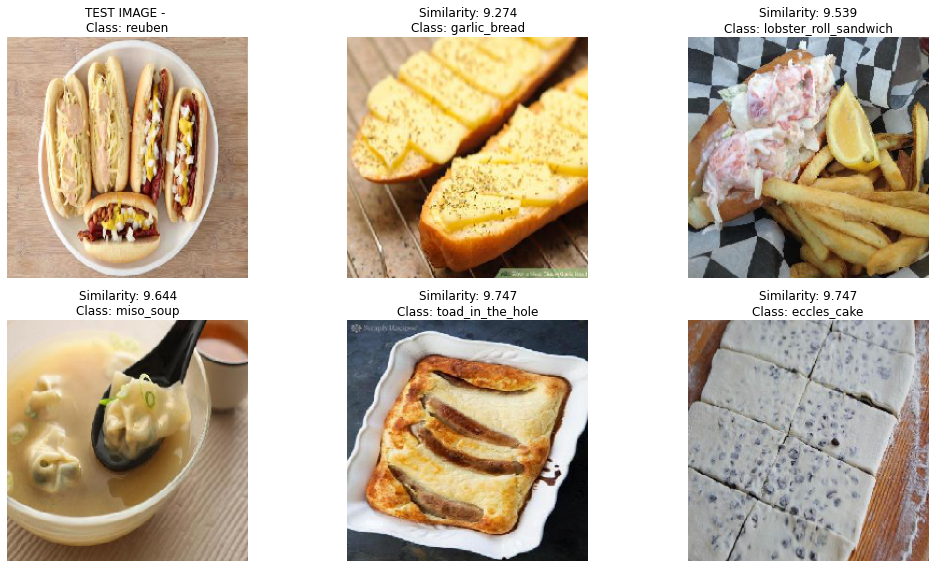

In [ ]:
plotSimilarImages(query_name, result.tolist()[0], dist.tolist()[0])

The selected example does not correctly identify any of the first 5 images.

## Evaluation

In [ ]:
val_info = pd.read_csv('val_info.csv', header=None)
lista_imvalid = val_info[1].tolist()
lista_imvalid = lista_imvalid[1:len(lista_imvalid)]
print(len(lista_imvalid))

11993


In [ ]:
li_accuracy = []

for query_name in lista_imvalid[1:100]:

  query_img = cv2.imread('val_set/' + query_name, flags=cv2.IMREAD_GRAYSCALE)
  query_img_class = getQueryLabel(query_name)

  query_desc = get_descriptors(query_img, detector)
  query_desc = np.float32(query_desc)

  if query_desc.shape != ():
      histogram = build_histogram(query_desc, kmeans)

      neighbor = NearestNeighbors(n_neighbors = 5)
      neighbor.fit(bow_akaze)
      dist, result = neighbor.kneighbors([histogram])
      result = result.tolist()[0]

      accuracy = 0
      for index in result:
        sim_path = bow_names[index]
        sim_class = getQueryLabel(sim_path.split('Train/')[1], train=True)
        if sim_class == query_img_class:
          accuracy += 1

      li_accuracy.append(accuracy/len(result))

In [ ]:
sum(li_accuracy) / len(li_accuracy)

0.06741573033707866

The proposed method does not perform very well, with an accuracy level of less than 7%.

## Example AKAZE

In [ ]:
name_img='train_000005.jpg'
path_img='Data/Train/'+name_img

In [ ]:
image = cv2.imread(filename = path_img,
                   flags = cv2.IMREAD_GRAYSCALE)

In [ ]:
image.shape

(256, 455)

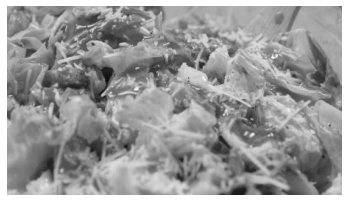

In [ ]:
# Create a new figure
plt.figure()
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# AKAZE is a feature detector and descriptor

# Initiate AKAZE detector
AKAZE = cv2.AKAZE_create(threshold = 0.002)

In [ ]:
 # Find the keypoints with KAZE
keypoints = AKAZE.detect(image, None)

# Print number of keypoints detected
print("Number of keypoints Detected:", len(keypoints), "\n")

Number of keypoints Detected: 202 



In [ ]:
# Save Keypoints to a file

index = []

for point in keypoints:
    temp = (point.pt,
            point.size,
            point.angle,
            point.response,
            point.octave, 
            point.class_id)
    
    index.append(temp)

In [ ]:
# Compute the descriptors with AKAZE
keypoints, descriptors = AKAZE.compute(image, keypoints)

# Print shape of descriptor
print("Shape of Descriptor:", descriptors.shape, "\n")

Shape of Descriptor: (202, 61) 



In [ ]:
# Draw only 50 keypoints on input image
image = cv2.drawKeypoints(image = image,
                         keypoints = keypoints,
                         outImage = None,
                         flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

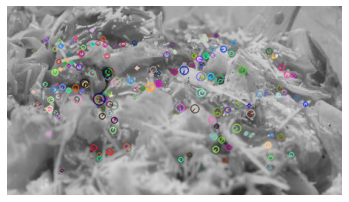

In [ ]:
# Plot input image

# Turn interactive plotting off
plt.ioff()

# Create a new figure
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

# Close it
plt.close()